# YearPredictionMSD dataset

Comparison of different inducing point GP-regression methods.

In [5]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [6]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/yearprediction(463715, 90).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'year prediction'
file_name = data_name

x_tr = x_tr.toarray()[:1e5 * 1.25, :].T
y_tr = y_tr[:1e5 * 1.25]
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 100000
of features 90
year prediction


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Linear SVM
We train an SVM with linear kernel for reference.

In [6]:
svm = LinearSVR(C=1e0)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.18896676527735246

In [7]:
np.sqrt(mean_squared_error(y_test, pred))

0.8886236132722114

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [8]:
ind_num = 500
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [10]:
# np.save('yearpred_inputs.npy', inputs)

In [7]:
inputs = np.load('yearpred_inputs.npy')
ind_num = inputs.shape[1]

In [8]:
cov_params = np.array([.8, 30., 1.2])
# cov_params = np.array([1., 1., .5])

In [9]:
default_plot_interval = [0., .3]
def plot_results(it_lst, t_lst, y_lst, clr, label, plot_interval=None):
    if plot_interval is None:
        plot_interval = default_plot_interval
    plt.figure(figsize=(13,5))

    plt.subplot(1, 2, 1)
    plt.plot(it_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Iterations')
    plt.ylabel('r2 score on test-set')

    plt.subplot(1, 2, 2)
    plt.plot(t_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Time(s)')
    plt.ylabel('r2 score on test-set')

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [6]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [7]:
opts = {'maxiter': 150, 'mydisp': True, 'print_freq': 1}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  0.8         30.           1.2         -2.10239123   0.85500267]
Hyper-parameters at iteration 1 : [  0.80284434  30.00000429   1.04075978  -2.10239123   0.85500267]
Hyper-parameters at iteration 2 : [  0.76909928  30.0011925    0.94424908  -2.10242159   0.85495448]
Hyper-parameters at iteration 3 : [  0.7298171   30.00248187   0.93180974  -2.10245365   0.85490063]
Hyper-parameters at iteration 4 : [  0.66098312  30.00506039   0.92522486  -2.10254319   0.85476504]
Hyper-parameters at iteration 5 : [  0.66864787  30.00518305   0.9265835   -2.10255521   0.85474642]
Hyper-parameters at iteration 6 : [  0.66846211  30.00569758   0.92613119  -2.10258326   0.85470375]
Hyper-parameters at iteration 7 : [  0.66811751  30.00776799   0.92536777  -2.10269639   0.85453153]
Hyper-parameters at iteration 8 : [  0.66778399  30.01387797   0.92422785  -2.10303023   0.85402278]
Hyper-parameters at iteration 9 : [  0.66772444  30.03156609   0.92241228  -2.10399554   0.

In [8]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'it', freq=1)

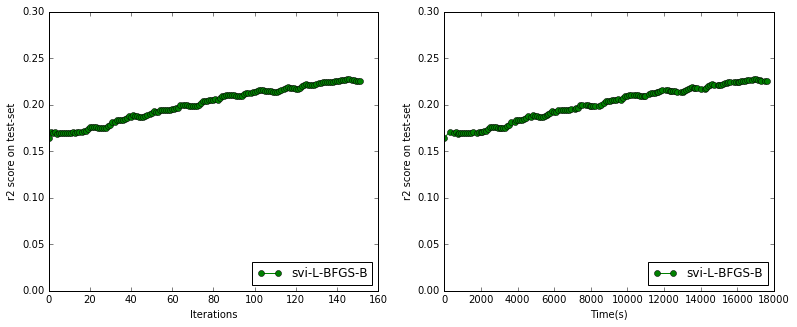

In [9]:
plot_results(lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst, '-go', 'svi-L-BFGS-B')

In [10]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xi.npy', lbfgs_svi_xi_lst)
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xt.npy', lbfgs_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [11]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [12]:
opts = {'maxiter': 50, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  0.8  30.    1.2]
Hyper-parameters at iteration 1 : [  1.00580242  30.0003107    1.19959647]
Hyper-parameters at iteration 2 : [  1.15580065  30.00201936   0.80471129]
Hyper-parameters at iteration 3 : [  1.00672087  30.00139335   0.98476344]
Hyper-parameters at iteration 4 : [  1.06713063  30.00182886   0.92127942]
Hyper-parameters at iteration 5 : [  1.11088763  30.00236711   0.89281945]
Hyper-parameters at iteration 6 : [  1.09112742  30.00248501   0.89911723]
Hyper-parameters at iteration 7 : [  1.09710583  30.00277374   0.89899228]
Hyper-parameters at iteration 8 : [  1.09240852  30.03577201   0.8979479 ]
Hyper-parameters at iteration 9 : [  1.08374262  30.23562968   0.8956346 ]
Hyper-parameters at iteration 10 : [  1.08018615  30.9671822    0.89104655]
Hyper-parameters at iteration 11 : [  1.10565835  33.05857061   0.88366017]
Hyper-parameters at iteration 12 : [  1.23321686  39.34998026   0.87020352]
Hyper-parameters at iteration 13 : [  1.568

In [13]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_xi_lst, vi_xt_lst, vi_y_lst = vi_res.plot_performance(metric, 'it', freq=1)

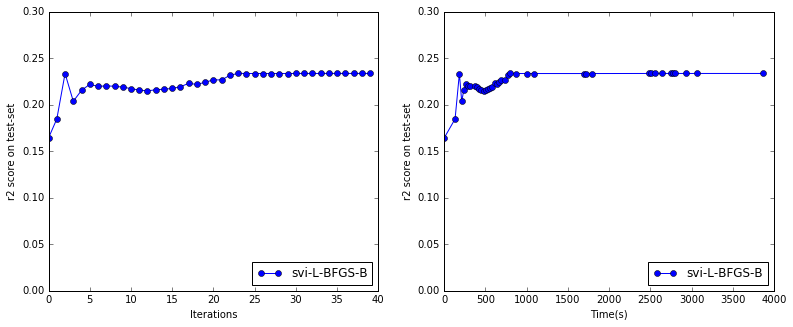

In [14]:
plot_results(vi_xi_lst, vi_xt_lst, vi_y_lst, '-bo', 'svi-L-BFGS-B')

In [15]:
vi_y_lst[-1]

0.23369841885480236

In [16]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xi.npy', vi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xt.npy', vi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [1]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

NameError: name 'SquaredExponential' is not defined

In [2]:
opts = {'mydisp': True, 'print_freq': 1, 'step_rate': 1.,
                'maxiter': 250, 'batch_size':500}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

NameError: name 'ad_svi_gp' is not defined

In [3]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'it', freq=1)

NameError: name 'ad_svi_res' is not defined

In [4]:
plot_results(ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst, '-ro', 'svi-L-BFGS-B')

NameError: name 'plot_results' is not defined

In [45]:
ad_svi_y_lst[-1]

0.18861937121845695

In [46]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xi.npy', ad_svi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xt.npy', ad_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)